In [129]:
import requests
import pandas as pd
import string
import re


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\whitl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
mm_access_token = "da9346f92c84282b249ab83d5c2d793c"

In [3]:
# Collect the artists that performed on the main stage at Coachella
coachella_perf = pd.read_csv("data/coachella_artists.csv")
coachella_artists = coachella_perf.drop_duplicates(subset='id')
name_list = coachella_artists['name'].to_list()

main_stage = coachella_perf[coachella_perf['stage'] == "Coachella Stage"].drop_duplicates('id')['name'].to_list()
main_stage

['Beck',
 'The Chemical Brothers',
 'Morrissey',
 'Modest Mouse',
 'Tool',
 'Rage Against the Machine',
 'Pavement',
 'Thievery Corporation',
 'Mix Master Mike',
 'Paul Oakenfold',
 'Weezer',
 'The Roots',
 'MC Supernatural',
 'Iggy Pop',
 'The Dandy Warhols',
 'Souls of Mischief',
 'Medusa',
 'Ozomatli',
 'Sigur Rós',
 'Björk',
 'Siouxsie & the Banshees',
 'Jack Johnson',
 'Pete Yorn',
 'G. Love & Special Sauce',
 'KRS-One',
 'Princess Superstar',
 'Vin Rock',
 'Queens of the Stone Age',
 'Saul Williams',
 'The  Noise Conspiracy',
 'Oasis',
 'The Prodigy',
 'Foo Fighters',
 'The Strokes',
 'Saves the Day',
 'Belle & Sebastian',
 'The Mars Volta',
 'Tiësto',
 'Beastie Boys',
 'Ben Harper & the Innocent Criminals',
 'Blur',
 'The Hives',
 'The Donnas',
 'The Mooney Suzuki',
 'Kinky',
 'Red Hot Chili Peppers',
 'Iggy and the Stooges',
 'The White Stripes',
 'Sonic Youth',
 'The Polyphonic Spree',
 'The Soundtrack of Our Lives',
 'Whirlwind Heat',
 'Interpol',
 'Café Tacvba',
 'Radiohead'

In [15]:
# Search each artist from the main stage for their top 5 tracks, parse response
mm_url = f"http://api.musixmatch.com/ws/1.1/track.search"
accepted = [] # songs where the artist matches the searched artist
rejected = [] # songs where the artist does not match the searched artist
for artist in main_stage:
    search_name = artist.lower()
    # Params filters the serach to the top 5 songs by the searched artist that have lyrics data on MusixMatch (top 5 by MusixMatch's own ranking)
    params = {"apikey": mm_access_token,
              "q_artist": search_name,
              "page_size": 5,
              "page": 1,
              "f_has_lyrics": True}
    response = requests.get(mm_url, params=params)
    for track in response.json()['message']['body']['track_list']:
        # parse the response
        tdata = track['track']
        row = {"name": artist,
        "artist_name": tdata['artist_name'],
        "track_name": tdata['track_name'],
        "track_id": tdata['track_id'],
        "source": tdata}
        if track['track']['artist_name'] != artist:
            rejected.append(row)
        else:
            accepted.append(row)

In [20]:
# Writing out the searched name and the name found for tracks where they do not match
# In the discrepancies.txt file, the rows where removed manually where the searched artist was not actually a part of the track
#   EX: Paul Oakenfold vs. Paul Oakenfold feat. Andy Gray
# This was done manually because of the amount of variation in artist names and formats for artist names from Spotify vs. MusixMatch
txt = ''
for t in rejected:
    txt += f"{t['name']}, {t['artist_name']}\n"
    
with open("data/discrepancies.txt", 'w') as f:
    f.write(txt)

In [28]:
# Read the final version of the discrepancies.txt to move the tracks that are correct into the accepted list
lines = []
with open("data/discrepancies.txt") as f:
    lines = f.readlines()

pairs = []
for l in lines:
    x = l.split(', ')
    x[1] = x[1].replace('\n', '') 
    pairs.append((x[0], x[1]))

In [30]:
# Move songs from the rejected list to the accepted list if they are in the discrepancies file.
count = 0
for entry in rejected:
    if (entry['name'], entry['artist_name']) in pairs:
        accepted.append(entry)
        print(entry)
        count += 1
count

{'name': 'The Chemical Brothers', 'artist_name': 'The Chemical Brothers feat. Miguel', 'track_name': 'This Is Not A Game - From "The Hunger Games: Mockingjay Part 1" Soundtrack', 'track_id': 84369062, 'source': {'track_id': 84369062, 'track_name': 'This Is Not A Game - From "The Hunger Games: Mockingjay Part 1" Soundtrack', 'track_name_translation_list': [], 'track_rating': 39, 'commontrack_id': 47417980, 'instrumental': 0, 'explicit': 0, 'has_lyrics': 1, 'has_subtitles': 1, 'has_richsync': 0, 'num_favourite': 3, 'album_id': 20900916, 'album_name': 'The Hunger Games: Mockingjay Pt. 1 (Original Motion Picture Soundtrack)', 'artist_id': 27955516, 'artist_name': 'The Chemical Brothers feat. Miguel', 'track_share_url': 'https://www.musixmatch.com/lyrics/The-Chemical-Brothers-feat-Miguel/This-Is-Not-A-Game-From-The-Hunger-Games-Mockingjay-Part-1-Soundtrack?utm_source=application&utm_campaign=api&utm_medium=Technical+University+of+Denmark%3A1409624530551', 'track_edit_url': 'https://www.musi

429

In [31]:
mm_track_data = pd.DataFrame(accepted)
mm_track_data.to_csv('data/mm_track_metadata.csv') # save as a checkpoint

In [44]:
lyrics = []

In [153]:
# Search each artist from the main stage for their top 5 tracks, parse response
mm_url = f"http://api.musixmatch.com/ws/1.1/track.lyrics.get"
mm_track_data = pd.read_csv("data/mm_track_metadata.csv")
 # songs where the artist does not match the searched artist
track_list = mm_track_data['track_id'].to_list()
for track_id in track_list:
    print(f"Searching: {track_id}")
    params = {"apikey": mm_access_token,
              "track_id": track_id}
    response = requests.get(mm_url, params=params)
    if not response.json()['message']['body']: # check for data
       print("Skipping")
       continue

    l = response.json()['message']['body']['lyrics']
    row = {"track_id": track_id,
           "text": l['lyrics_body'],
           "explicit": l['explicit'],
           "script_tracking_url": l["script_tracking_url"]}
    lyrics.append(row)

Searching: 35147897
Searching: 178403480
Searching: 43666506
Searching: 179156467
Searching: 976849
Searching: 63213649
Searching: 43508601
Searching: 558675
Searching: 88252574
Searching: 78167658
Searching: 2113579
Searching: 32226546
Searching: 84747864
Searching: 15089146
Searching: 17819242
Searching: 94825081
Searching: 4391000
Searching: 7578591
Searching: 7953467
Searching: 116534616
Searching: 215076354
Searching: 96336000
Searching: 89155388
Searching: 123705687
Searching: 87140017
Searching: 188319447
Searching: 187795063
Searching: 188323433
Searching: 4123728
Searching: 34202646
Searching: 84607892
Searching: 91220757
Searching: 93334925
Searching: 3383716
Searching: 93334901


In [56]:
lyrics_df = pd.DataFrame(lyrics)
lyrics_df = lyrics_df.drop_duplicates(subset='track_id')

In [66]:
artist_data = pd.read_csv("data/coachella_artists_full.csv")

In [84]:
# Adding some of the artist data (artist_name, artist_genres, artist_id) to the track dataset, formatting the table
full_track_data = lyrics_df.merge(mm_track_data, on='track_id', how='left')
full_track_data = full_track_data.drop('Unnamed: 0', axis=1)
full_track_data = full_track_data.drop('artist_name', axis=1)
full_track_data = full_track_data.merge(artist_data[['name', 'id', 'genres']], on='name', how='left')
full_track_data = full_track_data.rename(columns={'name': 'artist_name',
                                            'id': 'artist_id',
                                            'genres': 'artist_genres'})
full_track_data = full_track_data.drop_duplicates(subset='track_id').reset_index()
full_track_data = full_track_data.drop('index', axis=1)

In [86]:
# Save results
full_track_data.to_csv('data/song_lyrics_dataset.csv')

In [94]:
def clean_lyrics(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove commercial use flag from API
    if text.find("*******") != -1:
        text = text[:text.index("*******")]

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Clean lyrics including stopword removal
def clean_lyrics_ws(text):
    # Remove stopwords
    text = clean_lyrics(text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

#### Here we make two new lyrics columns. Both are cleaned, but one includes stopwords and one does not include stopwords.

In [95]:
full_track_data['cleaned_lyrics'] = full_track_data['text'].apply(clean_lyrics)
full_track_data['cleaned_lyrics_ws'] = full_track_data['text'].apply(clean_lyrics_ws)

### Sentiment Analysis
In this section of the notebook, we are analyzing the lyric data in the song_lyrics_dataset. First, we are finding the sentiment analysis of each song by tallying the number of positive, neutral, and negative sentences in the lyrics. We then sort the song in a positive, negative, or neutral sentiment depending on which category is most frequent.

In [141]:
def get_sentiment_score(lyrics):
    blob = TextBlob(lyrics)
    total_song_sentiment = 0

    for sentence in blob.sentences:
        # Perform sentiment analysis
        sentiment_score = sentence.sentiment.polarity
        total_song_sentiment += sentiment_score
    
    return total_song_sentiment

def analyze_sentiment_lyrics(lyrics):
    blob = TextBlob(lyrics)
    total_song_sentiment = 0

    # Initialize sentiment counters
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    for sentence in blob.sentences:
        # Perform sentiment analysis
        sentiment_score = sentence.sentiment.polarity
        total_song_sentiment += sentiment_score
        # Classify the sentence as positive, negative, or neutral
        if sentiment_score > 0:
            positive_count += 1
        elif sentiment_score < 0:
            negative_count += 1
        else:
            neutral_count += 1
    
    # Determine overall sentiment based on counts
    if positive_count > negative_count:
        overall_sentiment = "Positive"
    elif negative_count > positive_count:
        overall_sentiment = "Negative"
    else:
        overall_sentiment = "Neutral"
    
    return overall_sentiment

In [101]:
# Generate sentiment data
full_track_data['sentiment'] = full_track_data['cleaned_lyrics'].apply(analyze_sentiment_lyrics)
full_track_data['sentiment_score'] = full_track_data['cleaned_lyrics'].apply(get_sentiment_score)

In [150]:
# Write data to file
full_track_data.to_csv("data/lyrics_dataset.csv")

# **Textual Analysis**

In this section we will be analyzing the song lyric data from the lyrics_dataset.csv file. It is important to note that all songs in this dataset come from performers that performed on the Main Stage of Coachella, so we cannot draw any conclusions on the festival as a whole, just the Main Stage. This is simply a limitation of the amount of textual data we could collect without a subscription to any lyric API.

#### **Sentiment Analysis Results**
Below you will find histograms with the results of our sentiment analysis. 

The first histogram shows the total sentiment scores of every song in the dataset. A positive score means a positive sentiment and a negative score means a negative sentiment. We can see that there is a slight majority of songs that have a positive sentiment and the plot roughly follows a normal distribution. We expected songs to have more polarized sentiments, that is, there would be more songs that have large positive values or large negative values. Instead, it seems that most songs have relatively neutral sentiments, with few having strong positive or negative sentiments.


Further down, we have histograms for each year of Coachella performers. Each histogram shows the number of songs associated with that year (by associated we mean that the artist who wrote the song performed at Coachella on that year) that fell into each sentiment analysis category. From initial inspection, we can see that most years are predominantly positive in sentiment. Out of the 22 years, 17 had a majority of positive sentiment songs.

In [130]:
# Combine year data with the track data for analysis
right = artist_data[['id', 'year']].rename(columns={'id': 'artist_id'})
tracks_with_years = full_track_data.merge(right, on='artist_id', how='left')
sentiment_with_year = tracks_with_years[['artist_id', 'sentiment']]
sentiment_with_year = sentiment_with_year.sort_values(['sentiment', 'year'])

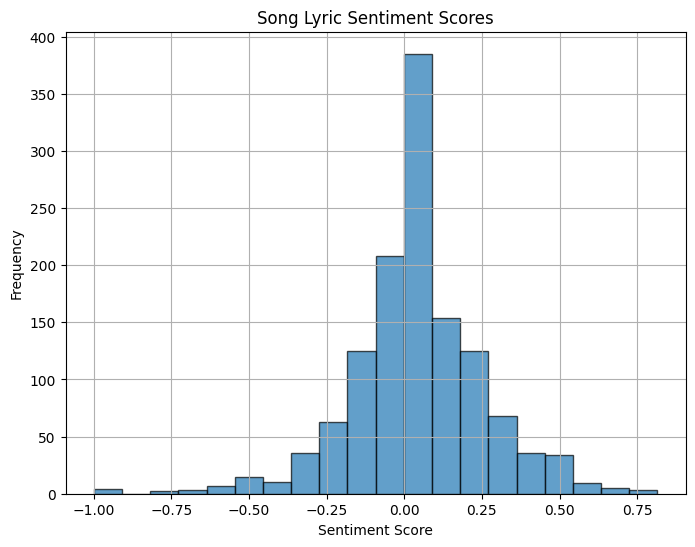

In [146]:
# Specify the number of bins for the histogram
num_bins = 20

# Plotting the histogram of sentiment scores with 10 bins
plt.figure(figsize=(8, 6))
plt.hist(full_track_data['sentiment_score'], bins=num_bins, edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Song Lyric Sentiment Scores')

# Display the plot
plt.grid(True)
plt.show()

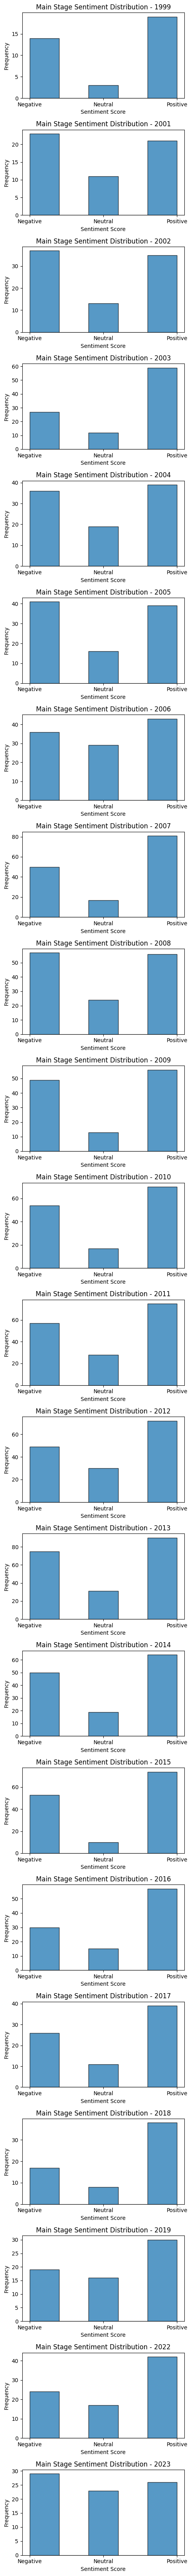

In [128]:
unique_years = sorted(sentiment_with_year['year'].unique())

# Set up subplots (one subplot per year)
fig, axs = plt.subplots(nrows=len(unique_years), figsize=(5, 3 * len(unique_years)))

# Iterate over unique years
for i, year in enumerate(unique_years):
    # Filter data for the current year
    data_year = sentiment_with_year[sentiment_with_year['year'] == year]['sentiment']
    
    # Plot histogram for the current year
    axs[i].hist(data_year, bins=5, alpha=0.75, edgecolor='black')
    axs[i].set_title(f'Main Stage Sentiment Distribution - {year}')
    axs[i].set_xlabel('Sentiment Score')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### **Word Clouds**
In addition to sentiment analysis, we wanted to generate word clouds to identify trends in lyrics in Main Stage performances. Below you can find word clouds for each year of the festival and all the way down, you will find a word cloud for all 22 years of the festival. 

There are a few trends within these clouds. Firstly, there are clearly groups of associated words that appear frequently, such as the "love song" group. This includes words such as: love, baby, babe, sexy, heart, etc. and could also include helper words such as: get, got, or tonight. There is also the appearance of other languages, mainly Spanish. It is very easy to tell which years included hispanic performers due to the appearance of que, el, la and other Spanish stopwords that were not removed by the English filter. 

Overall, there does not seem to be significant differences between the word clouds. It is difficult to spot trends in these word clouds as often the most interesting words appear only once while words that are common among traditional pop themes (ex: love songs) appear everywhere. This is not to say that the years are all the same but there are not many standout years.

1999


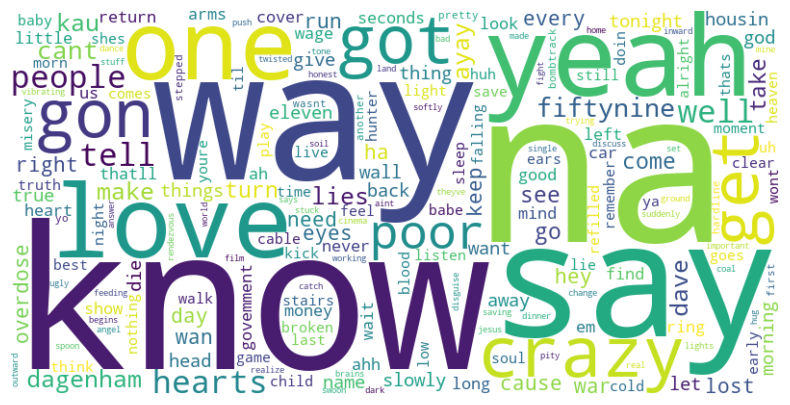

2001


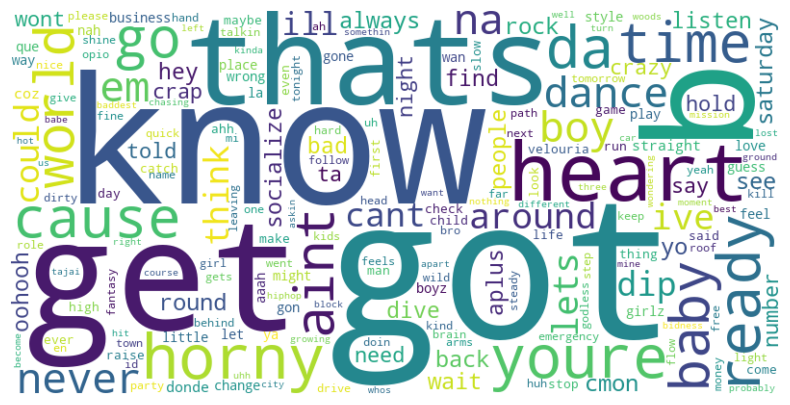

2002


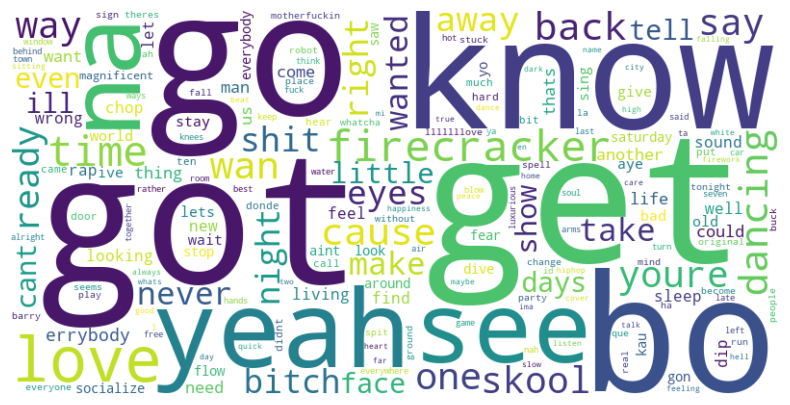

2003


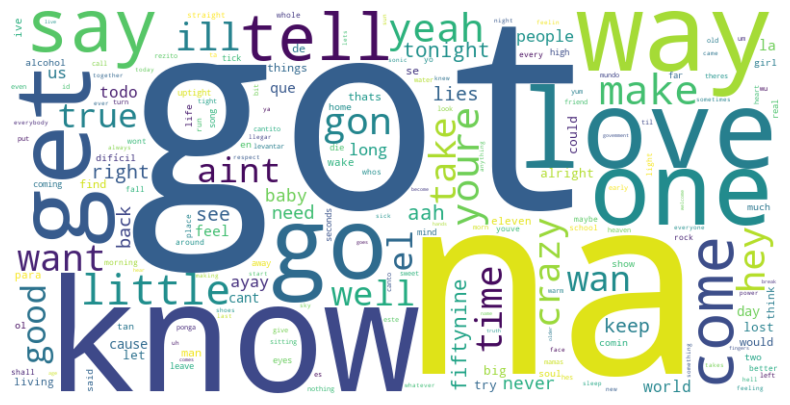

2004


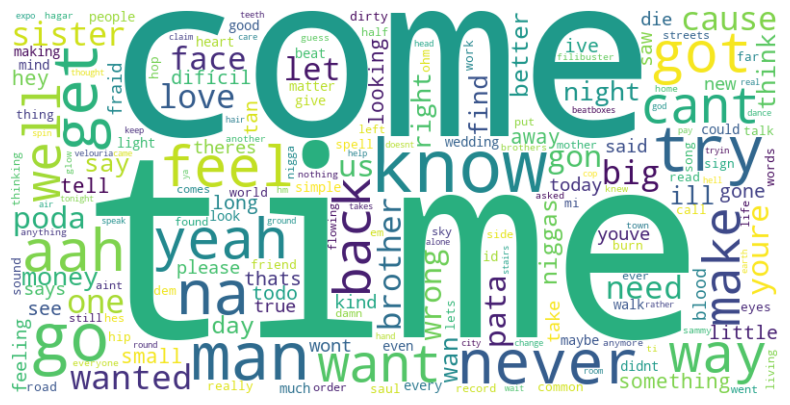

2005


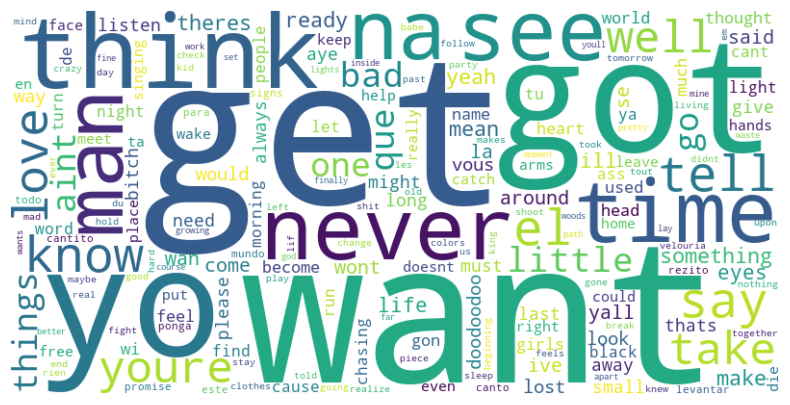

2006


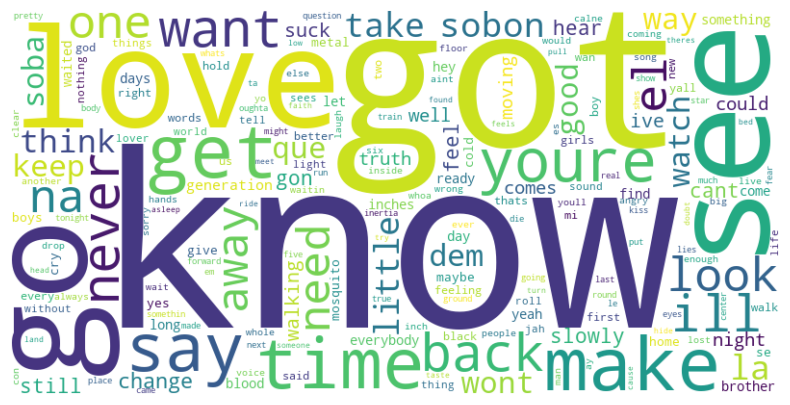

2007


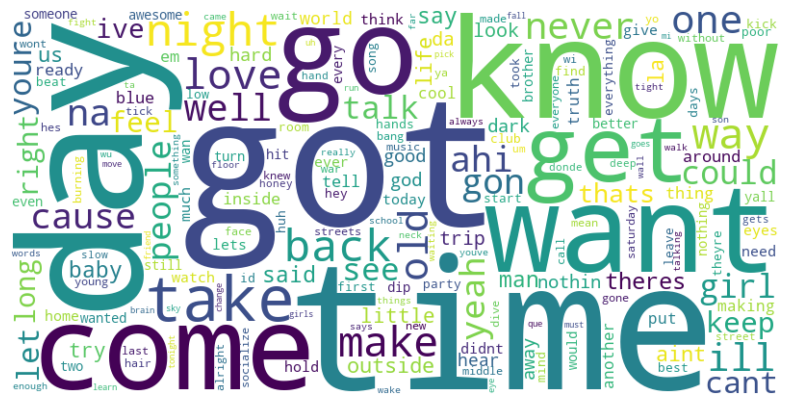

2008


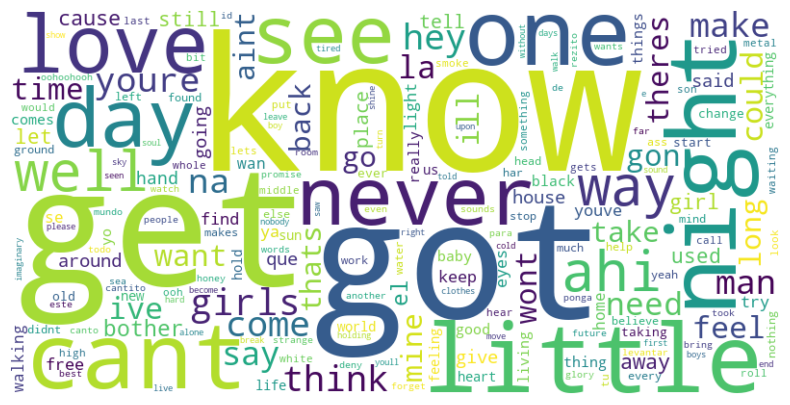

2009


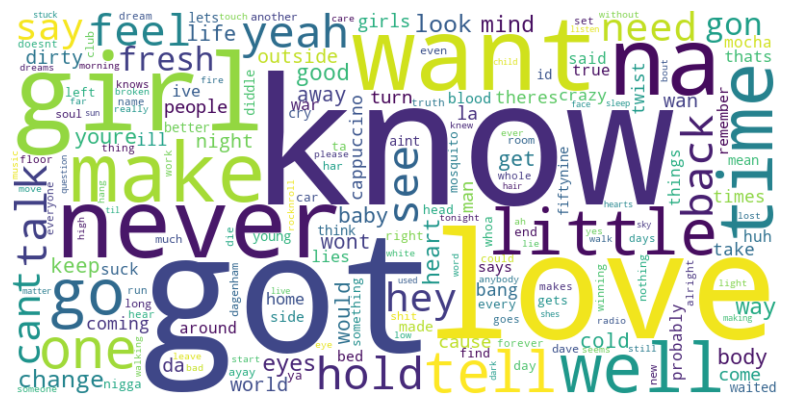

2010


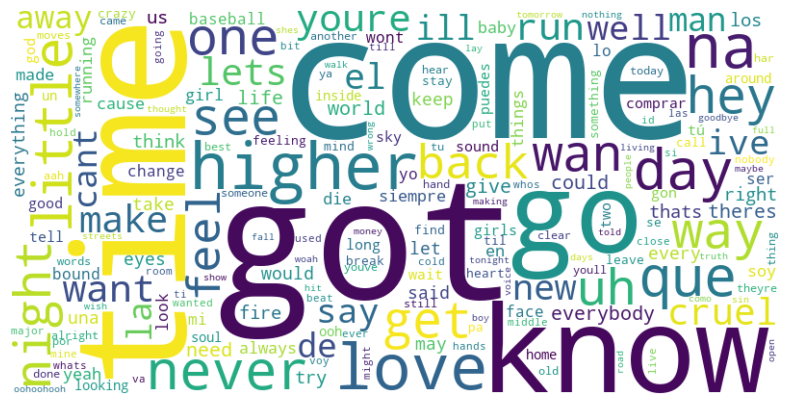

2011


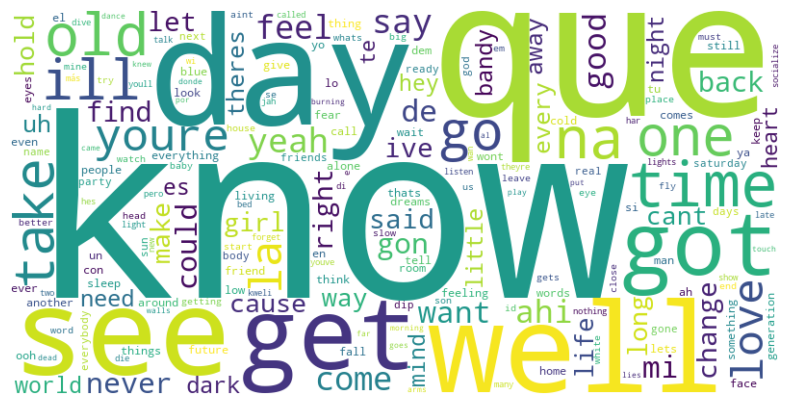

2012


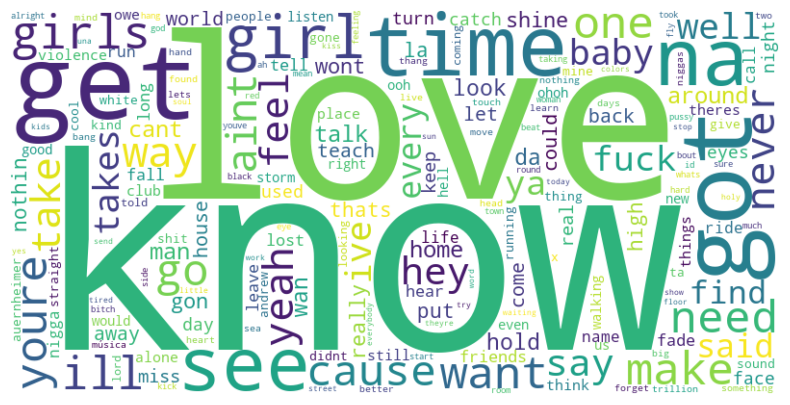

2013


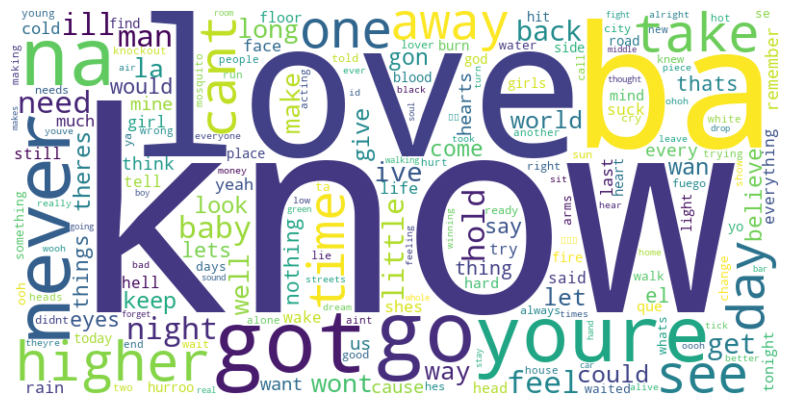

2014


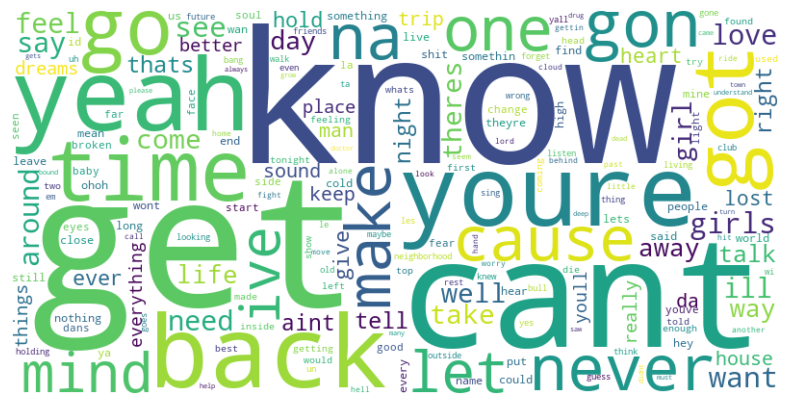

2015


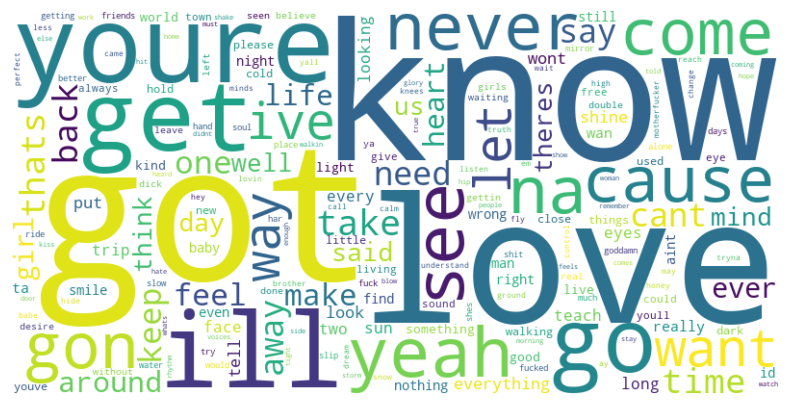

2016


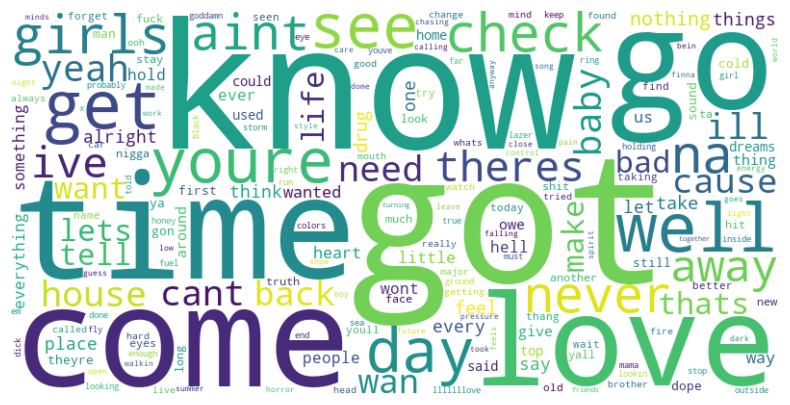

2017


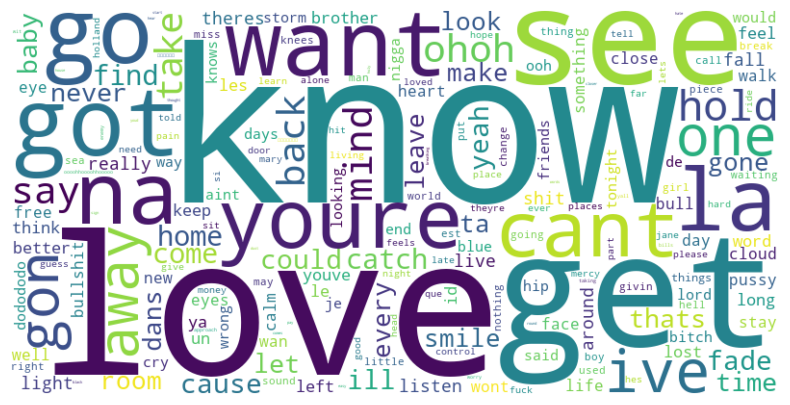

2018


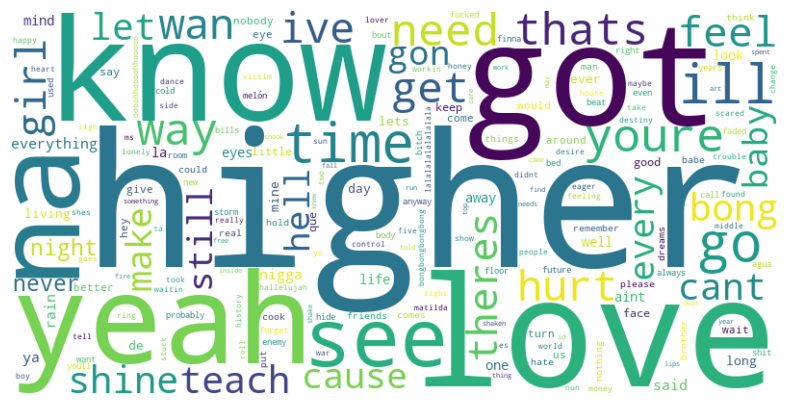

2019


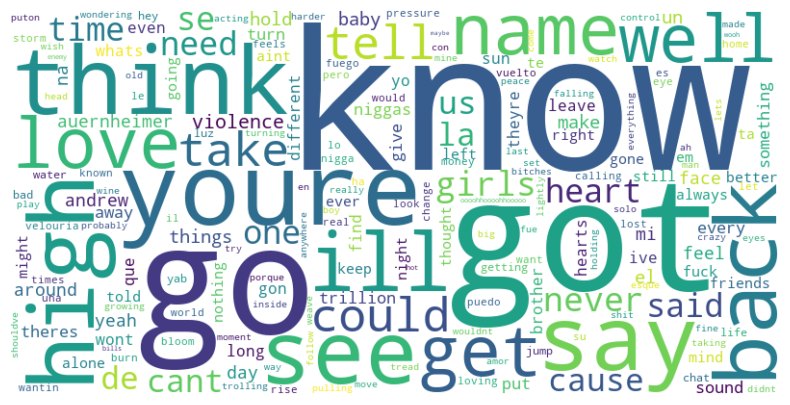

2022


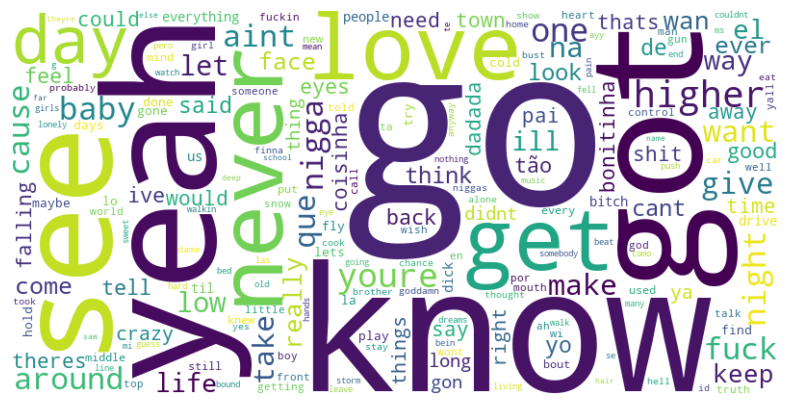

2023


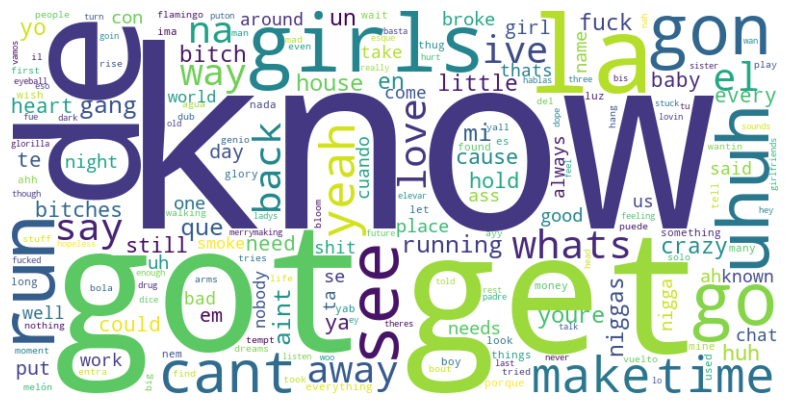

In [139]:
for i, year in enumerate(unique_years):
    # Initialize an empty list to store all tokens
    all_tokens = []
    texts = tracks_with_years[tracks_with_years['year'] == year]['cleaned_lyrics_ws'].to_list()
    # Tokenize, clean, and collect all tokens from each text
    for text in texts:
        # Tokenize the text into words
        tokens = word_tokenize(text.lower())
        # Removing some stopwords that were not caught in the initial filter
        filtered_tokens = [token for token in tokens if token not in ['im', 'like', 'dont', 'oh']]
        all_tokens.extend(filtered_tokens)

    # Calculate word frequencies using Counter from collections
    word_counts = Counter(all_tokens)

    # Create a WordCloud object and generate the word cloud from word counts
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    print(year)
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axis
    plt.show()

2023


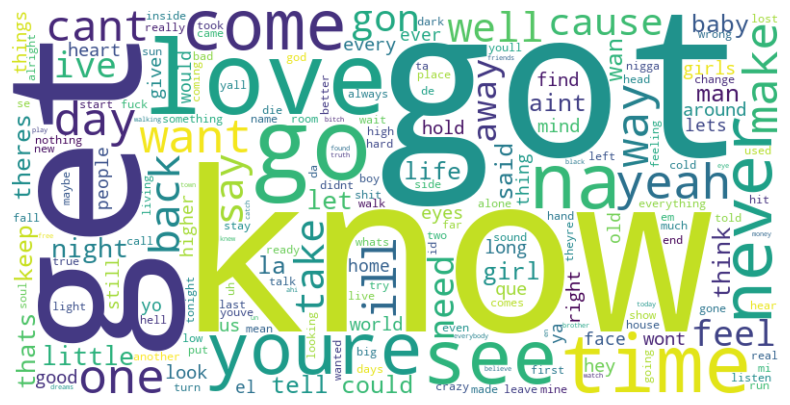

In [140]:
# Repeat the same process but for all years
all_tokens = []
texts = tracks_with_years['cleaned_lyrics_ws'].to_list()
# Tokenize, clean, and collect all tokens from each text
for text in texts:
    # Tokenize the text into words
    tokens = word_tokenize(text.lower())
    # Removing some stopwords that were not caught in the initial filter
    filtered_tokens = [token for token in tokens if token not in ['im', 'like', 'dont', 'oh']]
    all_tokens.extend(filtered_tokens)

# Calculate word frequencies using Counter from collections
word_counts = Counter(all_tokens)

# Create a WordCloud object and generate the word cloud from word counts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.show()